In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
## Import Packages
import os
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.preprocessing import sequence
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from random import shuffle
from keras import regularizers
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import SGD
from keras.datasets import imdb
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import StratifiedKFold
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Merge
from keras.layers import Input
import numpy as np
import keras


## AutoRate specific packages
import quadratic_kappa as kp
import quadratic_kappa as q
import normalize_features as nf

Using TensorFlow backend.
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the mo

In [3]:
import numpy as np
print(np.__version__)

1.16.1


In [4]:
### Function to pad videos with length of frames less than 52
def pad_videos(data, max_length):
    arr = []; count =0
    
    for i in range(data.shape[0]):
        x = data[i]
        if(x.shape[0] != max_length ):
            count+=1
            temp = []
            for j in range(max_length - x.shape[0]):
                temp.append(data[i][x.shape[0]-1])
            data[i] = np.concatenate((x, temp))
           # print("yes", i, x.shape[0])
        arr.append(data[i])
    print(count)
    return np.array(arr)

In [5]:
video_features2_Real, ground_truth2_Real = np.load("features_groundTruth2/Real_Allhandpicked_features_autorate.npy"), np.load("features_groundTruth2/Real_ground_truth_Allhandpicked_autorate.npy")
video_features2_Static, ground_truth2_Static = np.load("features_groundTruth2/Static_Allhandpicked_features_autorate.npy"), np.load("features_groundTruth2/Static_ground_truth_Allhandpicked_autorate.npy")
video_features2_Real_Static, ground_truth2_Real_Static = np.concatenate((video_features2_Real, video_features2_Static)), np.concatenate((ground_truth2_Real, ground_truth2_Static))

print("Real data  ", video_features2_Real.shape, ground_truth2_Real.shape)
print("Static data  ", video_features2_Static.shape, ground_truth2_Static.shape)
print("Real+Static data ", video_features2_Real_Static.shape, ground_truth2_Real_Static.shape)

Real data   (1078, 52, 152) (1078, 9)
Static data   (2161, 52, 152) (2161, 9)
Real+Static data  (3239, 52, 152) (3239, 9)


In [6]:
deep_features_Real, ground_truth_deep_features_Real = np.load("features_groundTruth2/Real_Allvggface_features_autorate.npy"), np.load("features_groundTruth2/Static_ground_truth_Allvggface_autorate.npy")
deep_features_Static, ground_truth_deep_features_Static = np.load("features_groundTruth2/Static_Allvggface_features_autorate.npy"), np.load("features_groundTruth2/Static_ground_truth_Allvggface_autorate.npy")

deep_features_Real = pad_videos(deep_features_Real, max_length = 52)
deep_features_Static = pad_videos(deep_features_Static, max_length = 52)
deep_features_Real_Static, ground_truth_deep_features_Real_Static = np.concatenate((deep_features_Real, deep_features_Static)), np.concatenate((ground_truth_deep_features_Real, ground_truth_deep_features_Static))

#######################3 Pad deep features ##################
from keras.preprocessing import sequence


deep_features_Real_Static = pad_videos(deep_features_Real_Static, max_length = 52)

print("Real data ", deep_features_Real.shape, ground_truth_deep_features_Real.shape)
print("Static data ", deep_features_Static.shape, ground_truth_deep_features_Static.shape)
print("Real + Static data ", deep_features_Real_Static.shape, ground_truth_deep_features_Real_Static.shape)

0
5
0
Real data  (1078, 52, 4096) (2161, 9)
Static data  (2161, 52, 4096) (2161, 9)
Real + Static data  (3239, 52, 4096) (4322, 9)


In [7]:
video_features2, ground_truth2 = video_features2_Real_Static, ground_truth2_Real_Static
deep_features, ground_truth_deep_features = deep_features_Real_Static, ground_truth_deep_features_Real_Static
print(video_features2.shape, ground_truth2.shape)
print(deep_features.shape, ground_truth_deep_features.shape)



(3239, 52, 152) (3239, 9)
(3239, 52, 4096) (4322, 9)


In [8]:
def shuffle_data(X, y):
    
    temp_X, temp_y = [], []
    x = np.arange(len(X))
    shuffle(x)
    
    for i in range(len(x)):
        temp_X.append(X[x[i]])
        temp_y.append(y[x[i]])
        
    return np.array(temp_X), np.array(temp_y)

In [9]:
video_features = deep_features_Real_Static
ground_truth = ground_truth_deep_features_Real_Static

In [10]:
def face_area(data):
    temp =[]
    for i in range(len(data)):
        x= data[i]
        for j in range(len(x)):
            if(x[j]<0):
                x[j]=0
        
        area = (x[3]-x[1])*(x[2]-x[0])
        temp.append(area)
        
    return np.array(temp)

def compute_face_area(arr):
    temp =[]
    
    for i in range(len(arr)):
        temp.append(face_area(arr[i]))
        
    return np.array(temp)


In [11]:
video_features_combined = np.concatenate((deep_features, video_features2[:,:,1].astype(float).reshape(video_features2.shape[0],video_features2.shape[1],1),compute_face_area(video_features2[:,:,2:6].astype(float)).reshape(video_features2.shape[0],video_features2.shape[1],1),video_features2[:,:,6:].astype(float) ),axis=2)
ground_truth_combined = ground_truth2
print("Deep Features + Hand Picked features", video_features_combined.shape, ground_truth_combined.shape)



Deep Features + Hand Picked features (3239, 52, 4244) (3239, 9)


In [12]:
## Divide the data into train, val and test
X_train, X_test1, y_train, y_test1 = train_test_split(video_features_combined, ground_truth_combined, test_size=0.35)
X_val, X_test, y_val, y_test = train_test_split( X_test1, y_test1, test_size=0.5)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)



(2105, 52, 4244) (2105, 9) (567, 52, 4244) (567, 9) (567, 52, 4244) (567, 9)


In [13]:
video_features_combined[0,0,4096:4108]

array([ 1.00000000e+00,  5.14040000e+04, -7.36480800e+00, -9.18400100e+00,
        5.19215470e+01, -3.67854595e+00, -2.42124939e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  2.95892615e-01,  1.10807528e-01])

In [14]:
train_video = X_train[:,:,:4096]
val_video= X_val[:,:,:4096]
test_video = X_test[:,:,:4096]

In [15]:
import normalize_features as nf

X_train_mod_specific_normalized, X_val_mod_specific_normalized = nf.inter_normalization(X_train[:,:,4096:], X_val[:,:,4096:])
X_train_mod_specific_normalized, X_test_mod_specific_normalized = nf.inter_normalization(X_train[:,:,4096:], X_test[:,:,4096:])



In [16]:
x = X_train_mod_specific_normalized.reshape(X_train.shape[0]*X_train.shape[1], X_train_mod_specific_normalized.shape[2])
y=  np.min(x[:,:12].astype(float),axis =0)
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
X_train_mod = np.concatenate((train_video , X_train_mod_specific_normalized), axis =2)
X_val_mod = np.concatenate((val_video , X_val_mod_specific_normalized), axis =2)
X_test_mod = np.concatenate((test_video , X_test_mod_specific_normalized), axis =2)

print("CNN + Handpicked features on0 train data", X_train_mod.shape)
print("CNN + Handpicked features on val data", X_val_mod.shape)
print("CNN + Handpicked features on test data", X_test_mod.shape)



CNN + Handpicked features on0 train data (2105, 52, 4244)
CNN + Handpicked features on val data (567, 52, 4244)
CNN + Handpicked features on test data (567, 52, 4244)


In [18]:
X_train_mod = np.load('data/X_train_mod_vggface.npy')
X_val_mod = np.load('data/X_val_mod_vggface.npy')
X_test_mod = np.load('data/X_test_mod_vggface.npy')
y_train = np.load('data/y_train_vggface.npy')
y_val = np.load('data/y_val_vggface.npy')
y_test= np.load('data/y_test_vggface.npy')

In [19]:
train_data = X_train_mod
train_label = y_train[:,7].astype(float).astype(int)
val_data = X_val_mod
test_data = X_test_mod
val_label = y_val[:,7].astype(float).astype(int)
test_label = y_test[:,7].astype(float).astype(int)

In [20]:
train_label_categorical = keras.utils.to_categorical(train_label - 1)
val_label_categorical = keras.utils.to_categorical(val_label - 1)
test_label_categorical = keras.utils.to_categorical(test_label - 1)

##  Attention LSTM

In [21]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt

fake = Faker()
fake.seed(12345)
random.seed(12345)

In [22]:
# Defined shared layers as global variables
repeator = RepeatVector(52)
concatenator = Concatenate(axis=-1)
densor_left1 = Dense(10, activation = "tanh", name='DenseLeft1')
densor_left2 = Dense(1, activation = "relu", name='DenseLeft2')
activator_left = Activation(softmax, name='attention_weights_left') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [23]:
# Defined shared layers as global variables
repeator = RepeatVector(52)
concatenator = Concatenate(axis=-1)
densor_right1 = Dense(10, activation = "tanh", name='DenseRight1')
densor_right2 = Dense(1, activation = "relu", name='DenseRight2')
activator_right = Activation(softmax, name='attention_weights_right') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [24]:
# GRADED FUNCTION: one_step_attention

def one_step_attention_left(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor_left1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor_left2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator_left(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [25]:
# GRADED FUNCTION: one_step_attention

def one_step_attention_right(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e_right = densor_right1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies_right = densor_right2(e_right)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator_right(energies_right)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [26]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(16, activation=softmax)

In [27]:
# GRADED FUNCTION: model

def model_left(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size, i):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size), name= 'X'+str(i))
    s0 = Input(shape=(n_s,), name='s0'+str(i))
    c0 = Input(shape=(n_s,), name='c0'+str(i))
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True, name='bidirectional_1_left'), merge_mode='concat')(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention_left(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=(X, s0, c0), outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [28]:
# GRADED FUNCTION: model

def model_right(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size, i):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size), name= 'X'+str(i))
    s0 = Input(shape=(n_s,), name='s0'+str(i))
    c0 = Input(shape=(n_s,), name='c0'+str(i))
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True, name='bidirectional_1_right'), merge_mode='concat')(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention_right(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=(X, s0, c0), outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [29]:
from keras.layers.merge import concatenate
model1 = model_left(52, 1, n_a, n_s, 4096, 5,0)
model2 = model_right(52, 1, n_a, n_s, 12, 5,1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [30]:
model = Sequential()
model.add(Merge([model1, model2], mode = 'concat'))
model.add(Dense(256, activation='relu'))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 1,114,943
Trainable params: 1,114,943
Non-trainable params: 0
_________________________________________________________________
None


/home/isha.d/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [31]:
### START CODE HERE ### (≈2 lines)
from keras import optimizers

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
### END CODE HERE ###

In [32]:
s0 = np.zeros((train_data.shape[0], n_s))
c0 = np.zeros((train_data.shape[0], n_s))
train_label_categorical2 =train_label_categorical.reshape((train_data.shape[0],1,5))
train_label_categorical2 = list(train_label_categorical2.swapaxes(0,1))

In [33]:
s1 = np.zeros((val_data.shape[0], n_s))
c1 = np.zeros((val_data.shape[0], n_s))
val_label_categorical2 =val_label_categorical.reshape((val_data.shape[0],1,5))
val_label_categorical2 = list(val_label_categorical2.swapaxes(0,1))

In [34]:
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0.01, patience =3, verbose =1, mode ='auto')

# history = model.fit([train_data, s0, c0], train_label_categorical2, epochs=200, batch_size=40, callbacks=[earlystopping],
#         class_weight = 'balanced',validation_data=([val_data, s1, c1], val_label_categorical2), verbose=1, shuffle= True)


In [35]:

history = model.fit([train_data[:,:,:4096], s0, c0, train_data[:,:,4096:4108], s0, c0], train_label_categorical2, epochs=200, batch_size=40, callbacks=[earlystopping],
        class_weight = 'balanced',validation_data=([val_data[:,:,:4096], s1, c1, val_data[:,:,4096:4108], s1, c1], val_label_categorical2), verbose=1, shuffle= True)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2105 samples, validate on 567 samples
Epoch 1/200
2105/2105 [==============================] - 23s 11ms/step - loss: 1.4969 - acc: 0.3667 - val_loss: 1.3933 - val_acc: 0.4339
Epoch 2/200
2105/2105 [==============================] - 17s 8ms/step - loss: 1.2111 - acc: 0.5530 - val_loss: 1.0729 - val_acc: 0.5908
Epoch 3/200
2105/2105 [==============================] - 17s 8ms/step - loss: 0.9721 - acc: 0.6361 - val_loss: 0.9973 - val_acc: 0.6296
Epoch 4/200
2105/2105 [==============================] - 17s 8ms/step - loss: 0.8274 - acc: 0.6836 - val_loss: 0.8956 - val_acc: 0.6596
Epoch 5/200
2105/2105 [==============================] - 17s 8ms/step - loss: 0.7589 - acc: 0.6969 - val_loss: 0.7866 - val_acc: 0.6755
Epoch 6/200
2105/2105 [==============================] - 16s 8ms/step - loss: 0.7015 - acc: 0.7207 - val_loss: 0.9246 - val_acc: 0.6226
Epoch 7/20

/home/isha.d/.local/lib/python3.5/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's00:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'c00:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
/home/isha.d/.local/lib/python3.5/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's01:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'c01:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Saved model to disk


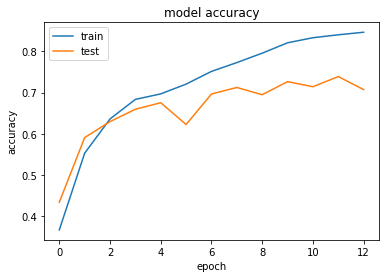

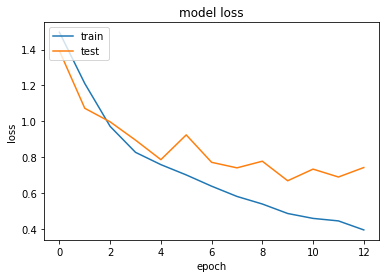

In [36]:
# serialize model to JSON
model_json = model.to_json()
with open("weights/AttentionLSTM-Merge_VGGFace/weights.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("weights/AttentionLSTM-Merge_VGGFace/weights.h5")
print("Saved model to disk")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [37]:
prediction = model.predict([val_data[:15,:,:4096], s0, c0, val_data[:15,:,4096:4108], s0, c0])
prediction = np.argmax(prediction, axis = -1)
print(prediction, np.argmax(val_label_categorical[:15], axis =1))


[4 0 0 3 4 0 4 4 0 4 0 0 3 4 0] [4 0 0 3 3 0 4 4 0 4 1 0 3 4 0]


In [38]:
def evaluate_model(data, label):
    prediction = model.predict([data[:,:,:4096], s0, c0, data[:,:,4096:4108], s0, c0])
    prediction = np.argmax(prediction, axis = -1)+1
    acc =0; s=0
    for i in range(len(label)):
        if(prediction[i]==label[i]):
            s+=1
    acc = (s*100)/len(label)
    print("Accuracy", acc)
    
    print(confusion_matrix(prediction, label))
    print(classification_report(prediction, label))
    return acc, np.concatenate((np.array(label).reshape((len(label),1)), np.array(prediction).reshape((len(prediction),1))),axis=1)

In [39]:
train_acc, train_prediction = evaluate_model(train_data, train_label)
val_acc, val_prediction = evaluate_model(val_data, val_label)
test_acc, test_prediction= evaluate_model(test_data, test_label)
# print(train_acc, val_acc, test_acc)

Accuracy 88.74109263657957
[[510   7   0   1   2]
 [  0 150  40   0   0]
 [  0  27 162  20   0]
 [  3   6  71 305  41]
 [  0   0   0  19 741]]
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       520
           2       0.79      0.79      0.79       190
           3       0.59      0.78      0.67       209
           4       0.88      0.72      0.79       426
           5       0.95      0.97      0.96       760

    accuracy                           0.89      2105
   macro avg       0.84      0.85      0.84      2105
weighted avg       0.90      0.89      0.89      2105

Accuracy 70.72310405643739
[[116   8   1   3   0]
 [  1  25  10   4   1]
 [  1  16  33   9   3]
 [  2   4  24  54  49]
 [  2   1   3  24 173]]
              precision    recall  f1-score   support

           1       0.95      0.91      0.93       128
           2       0.46      0.61      0.53        41
           3       0.46      0.53      0.50        62
        

In [40]:
import quadratic_kappa as q

def eval_kappa(gt_file, data):
    eval_new = np.concatenate((gt_file[:,1:6], data),axis =1)
    eval_all = eval_new[:,:7].astype(float).astype(int)
    kappa_values =[]
    for i in range(6):
        r1 = eval_all[:,i]
        p1 = eval_all[:,6]
        #print(r1,p1)
        arr = np.concatenate((r1.reshape(len(r1),1),p1.reshape(len(p1),1)),axis =1)
        qkappa1 = q.quadratic_kappa(arr, arr.shape[1])
        #print(qkappa1)
        kappa_values.append(qkappa1)

    #print(np.array(kappa_values).shape)
    kappa_values.append(np.mean(np.array(kappa_values)[:5]))
    return kappa_values

training =np.array(eval_kappa(y_train, train_prediction))
validation = np.array(eval_kappa(y_val, val_prediction))
testing = np.array(eval_kappa(y_test, test_prediction))

print("Kappa on training data", training.reshape(len(training),1))
print("Kappa on validation data", validation.reshape(len(validation),1))
print("Kappa on testing data", testing.reshape(len(testing),1))

Kappa on training data [[0.90471601]
 [0.91587337]
 [0.9374438 ]
 [0.93172433]
 [0.91312883]
 [0.97114205]
 [0.92057727]]
Kappa on validation data [[0.83986495]
 [0.8733425 ]
 [0.87734182]
 [0.87531295]
 [0.85872931]
 [0.89385428]
 [0.86491831]]
Kappa on testing data [[0.86630043]
 [0.88843758]
 [0.90345331]
 [0.89686384]
 [0.86203426]
 [0.91895032]
 [0.88341788]]


In [41]:
def plot_map(video, ground_truth):
    n_s = 64;
    num = 7; Tx = 52; Ty =1
    
    attention_map = np.zeros((1, 52))
    attention_map2 = np.zeros((1, 52))
    attention_map3 = np.zeros((12, 52))
    attention_map5 = np.zeros((52,12))
    attention_map4 = np.zeros(( 12,1))
    
    Ty, Tx = attention_map.shape
    Ty2, Tx2 = attention_map2.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    
    layer1 = model1.layers[7]
    layer2 = model2.layers[7]
    layer3 = model2.layers[0]
    
    f1 = K.function(model1.inputs, [layer1.get_output_at(t) for t in range(Ty)])
    r1 = f1([video[:,:4096].reshape(1,52, 4096), s0, c0])
    
    f2 = K.function(model2.inputs, [layer2.get_output_at(t) for t in range(Ty)])
    r2 = f2([video[:,4096:4108].reshape(1,52, 12), s0, c0])
    
    f3 = K.function(model2.inputs, [layer3.get_output_at(t) for t in range(Ty)])
    r3 = f3([video[:,4096:4108].reshape(1,52, 12), s0, c0])
  
   # print(np.array(r2).shape,np.array(r3).shape)
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r1[t][0,t_prime,0]
            
    for t1 in range(Ty):
        for t_prime1 in range(Tx):
            attention_map2[t1][t_prime1] = r2[t1][0,t_prime1,0]
            
    for t2 in range(12):
        for t_prime2 in range(Tx): 
            attention_map3[t2][t_prime2] = r3[0][0,t_prime2,t2]
            
#     print(attention_map3.shape, attention_map3[0,:])
            
   # print(attention_map)
    prediction = model.predict([video[:,:4096].reshape((1,52, 4096)), s0, c0,video[:,4096:4108].reshape((1,52, 12)), s0, c0])
    predicted_text = []
    for i in range(len(prediction)):
    #print(i)
        predicted_text.append(int(np.argmax(prediction[i])))
    print(" Actual is ==> ",ground_truth[7].astype(float).astype(int),"predicted is ==> ",predicted_text[0]+1 )
   

    # Plot the attention_map
    #plt.clf()
    plt.figure(figsize=(80, 60))
    plt.axis('off')
#     h =plt.ylabel('Generic Features', fontsize=65, labelpad = 260)
#     h.set_rotation(0)
    plt.imshow(attention_map, interpolation='nearest', cmap='Blues')
    plt.show()

    #plt.clf()
    plt.figure(figsize=(80, 60))
    plt.axis('off')
#     h =plt.ylabel('Specific Features', fontsize=65, labelpad = 260)
#     h.set_rotation(0)
    i = plt.imshow(attention_map2, interpolation='nearest', cmap='Blues')
    plt.show()

    for i in range(attention_map3.shape[0]):
        attention_map4 = attention_map3[i,:].reshape((1,52))
        plt.figure(figsize=(80, 60))
        #plt.add_subplot(1, 1, 1)
        plt.axis('off')
        plt.imshow(attention_map4,  interpolation='nearest', cmap='Oranges')
        plt.show()


In [42]:
l =['Face Detection', 'Face Area', 'Roll', 'Pitch', 'Yaw', 'EyeGaze_x', 'EyeGaze_y', 'Phone', 'Seatbelt', 'Landmark', 'EAR', 'MAR']
len(l)

12

In [43]:
from PIL import Image
def plot_frames(x):
    i =1; im2 = []
    while(i<=52):
        if(i<=9):
            name = "0000" +str(i)
        elif(i<=99):
            name = "000" + str(i)
        
        filename = x +"/output_" + name +".png"
        #print(filename)
        im = Image.open(filename)
        if(i ==1):
            im2 = im 
            i=i+4
            continue
        im2 = np.concatenate((im2, im),axis =1)
        i = i+4

    plt.figure(figsize=(80, 400))
    plt.axis('off')
    plt.imshow(im2, interpolation='nearest', cmap='Blues')
    plt.show()
    #return im2
    
        
    

In [44]:
def video_names(ground_truth_data):
    video_names = ground_truth_data[:,0]
    video_names_processed = []; video_final_list = []

    for i in range(len(video_names)):
            video_data = list(video_names[i].replace("./data/","").split("/"))
            video_data = list(filter(None, video_data))
            video_names_processed.append(video_data)

    video_names_processed = np.array(video_names_processed)
    video_data_names =  video_names_processed

    for i in range(len(video_data_names)):
        video = np.array(video_data_names[i])
        #print(i, len(video))
        if(len(video)<3):
            input_feature = "/ssd_scratch/cvit/isha2/dataset/hams_dataset1_processed3/" +str(video[0])+"/" + str(video[1])[:-4] +".mp4"
        
        elif(len(video)==3):
            input_feature = "/ssd_scratch/cvit/isha2/dataset/" + str(video[0]) +"/"  +str(video[1]) +"/" + str(video[2])[:-4] +".mp4"
           # print(input_feature)
        if(os.path.exists(input_feature)):
            video_final_list.append(input_feature)
 
    return video_final_list

In [45]:
# x = video_names(ground_truth_combined)
# k =0
# for i in range(1):
#     k = i*20
#     !ffmpeg -i "{x[k]}"   -loglevel panic dataset/output_%05d.png
#     plot_frames("dataset/")
#     plot_map(video_features_combined[k], ground_truth_combined[k])
#     print("\n \n \n")
    
    


In [46]:
# x = video_names(ground_truth_combined)
# k = 1500
# for i in range(20):
#     k = k + 40
#     !ffmpeg -i "{x[k]}"   -loglevel panic dataset/output_%05d.png
#     plot_frames("dataset/")
#     plot_map(video_features_combined[k], ground_truth_combined[k])
#     print("\n \n \n")

In [47]:
def predicted_value(video, ground_truth):
    n_s = 64;
    num = 7; Tx = 52; Ty =1
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    
    # print(attention_map)
    prediction = model.predict([video[:,:4096].reshape((1,52, 4096)), s0, c0,video[:,4096:4108].reshape((1,52, 12)), s0, c0])
    predicted_text = []
    for i in range(len(prediction)):
    #print(i)
        predicted_text.append(int(np.argmax(prediction[i])))

    return ground_truth[7].astype(float).astype(int), predicted_text[0]+1 
   


In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def create_dynamic_videos(video, ground_truth):
    
    plt.style.use('dark_background')
#     for j in range(52):
#         print(j)
#         plt.style.use('dark_background')
#         img1 = mpimg.imread('dataset/output_'+str(j+1).zfill(5)+'.png')
#         plt.figure(figsize=(8, 8)) 
#         plt.axis('off')
#         plt.imshow(img1)
#         plt.savefig('faltu/img1_'+str(j+1)+'.png', bbox_inches="tight", pad_inches=0, transparent= True)
#         plt.close()

    xdata1 = []; ydata1 = []; 
    xdata2 = []; ydata2 = [];
    xdata3 = []; ydata3 = [];
    xdata4 = []; ydata4 = [];
    xdata5 = []; ydata5 = [];
    xdata6 = []; ydata6 = [];
    xdata7 = []; ydata7 = [];
    xdata8 = []; ydata8 = [];
    xdata9 = []; ydata9 = [];
    xdata10 = []; ydata10 = [];
    #plt.show() 

    for i in range(52):
        print(i)
        fig = plt.figure(figsize=(12,10),frameon=True)
        ax = fig.subplots(10, 1)
       #fig.tight_layout()

        ax[0].set_xlim(0, 52)
        #ax[0].set_ylim(0, 329400)
        ax[0].locator_params(axis='y', nbins=3)
        ax[0].set_ylabel('Face Area', rotation=0, fontsize=20, labelpad=60)
        line, = ax[0].plot(xdata1, ydata1, 'g-', linewidth=4.0)
        xdata1.append(i)
        ydata1.append(video[i,4097])
        line.set_xdata(xdata1)
        line.set_ydata(ydata1)

        ax[1].set_xlim(0, 52)
        #ax[1].set_ylim(-180, 180)
        ax[1].locator_params(axis='y', nbins=3)
        ax[1].set_ylabel('Roll', rotation=0, fontsize=20, labelpad=60)
        line, = ax[1].plot(xdata2, ydata2, 'g-', linewidth=4.0)
        xdata2.append(i)
        ydata2.append(video[i,4098])
        line.set_xdata(xdata2)
        line.set_ydata(ydata2)


        ax[2].set_xlim(0, 52)
       # ax[2].set_ylim(-180, 180)
        ax[2].locator_params(axis='y', nbins=3)
        ax[2].set_ylabel('Pitch', rotation=0, fontsize=20, labelpad=60)
        line, = ax[2].plot(xdata3, ydata3, 'g-', linewidth=4.0)
        xdata3.append(i)
        ydata3.append(video[i,4099])
        line.set_xdata(xdata3)
        line.set_ydata(ydata3)

        ax[3].set_xlim(0, 52)
       # ax[3].set_ylim(-180, 180)
        ax[3].locator_params(axis='y', nbins=3)
        ax[3].set_ylabel('Yaw', rotation=0, fontsize=20, labelpad=60)
        line, = ax[3].plot(xdata4, ydata4, 'g-', linewidth=4.0)
        xdata4.append(i)
        ydata4.append(video[i,4100])
        line.set_xdata(xdata4)
        line.set_ydata(ydata4)


        ax[4].set_xlim(0, 52)
       # ax[4].set_ylim(-180, 180)
        ax[4].locator_params(axis='y', nbins=3)
        ax[4].set_ylabel('EyeGaze_X', rotation=0, fontsize=20, labelpad=60)
        line, = ax[4].plot(xdata5, ydata5, 'g-', linewidth=4.0)
        xdata5.append(i)
        ydata5.append(video[i,4101])
        line.set_xdata(xdata5)
        line.set_ydata(ydata5)

        ax[5].set_xlim(0, 52)
       # ax[5].set_ylim(-180, 180)
        ax[5].locator_params(axis='y', nbins=3)
        ax[5].set_ylabel('EyeGaze_Y', rotation=0, fontsize=20, labelpad=60)
        line, = ax[5].plot(xdata6, ydata6, 'g-', linewidth=4.0)
        xdata6.append(i)
        ydata6.append(video[i,4102])
        line.set_xdata(xdata6)
        line.set_ydata(ydata6)

        if(int(video[i,4103]) == 0):
            ax[6].set_xlim(0, 52)
           # ax[6].set_ylim(0,1)
            ax[6].locator_params(axis='y', nbins=3)
            ax[6].set_ylabel('Phone', rotation=0, fontsize=20, labelpad=60)
            line, = ax[6].plot(xdata7, ydata7, 'g-', linewidth=4.0)
            xdata7.append(i)
            ydata7.append(video[i,4103])
            line.set_xdata(xdata7)
            line.set_ydata(ydata7)
            
        elif(int(video[i,4103]) == 1):
            ax[6].set_xlim(0, 52)
           # ax[6].set_ylim(0,1)
            ax[6].locator_params(axis='y', nbins=3)
            ax[6].set_ylabel('Phone', rotation=0, fontsize=20, labelpad=60)
            line, = ax[6].plot(xdata7, ydata7, 'r-', linewidth=4.0)
            xdata7.append(i)
            ydata7.append(video[i,4103])
            line.set_xdata(xdata7)
            line.set_ydata(ydata7)

        if(int(video[i,4104]) == 1):
            ax[7].set_xlim(0, 52)
           # ax[7].set_ylim(0,1)
            ax[7].locator_params(axis='y', nbins=3)
            ax[7].set_ylabel('Seatbelt', rotation=0, fontsize=20, labelpad=60)
            line, = ax[7].plot(xdata8, ydata8, 'g-', linewidth=4.0)
            xdata8.append(i)
            ydata8.append(video[i,4104])
            line.set_xdata(xdata8)
            line.set_ydata(ydata8)

        elif(int(video[i,4104]) == 0):
            ax[7].set_xlim(0, 52)
           # ax[7].set_ylim(0,1)
            ax[7].locator_params(axis='y', nbins=3)
            ax[7].set_ylabel('Seatbelt', rotation=0, fontsize=20, labelpad=60)
            line, = ax[7].plot(xdata8, ydata8, 'r-', linewidth=4.0)
            xdata8.append(i)
            ydata8.append(video[i,4104])
            line.set_xdata(xdata8)
            line.set_ydata(ydata8)
            
            
        ax[8].set_xlim(0, 52)
       # ax[8].set_ylim(0,10)
        ax[8].locator_params(axis='y', nbins=3)
        ax[8].set_ylabel('EAR', rotation=0, fontsize=20, labelpad=60)
        line, = ax[8].plot(xdata9, ydata9, 'g-', linewidth=4.0)
        xdata9.append(i)
        ydata9.append(video[i,4106])
        line.set_xdata(xdata9)
        line.set_ydata(ydata9)

        ax[9].set_xlim(0, 52)
       # ax[9].set_ylim(0,10)
        ax[9].locator_params(axis='y', nbins=3)
        ax[9].set_ylabel('MAR', rotation=0, fontsize=20, labelpad=60)
        line, = ax[9].plot(xdata10, ydata10, 'g-', linewidth=4.0)
        xdata10.append(i)
        ydata10.append(video[i,4107])
        line.set_xdata(xdata10)
        line.set_ydata(ydata10)

        fig.savefig('faltu/img2_'+str(i+1)+'.png', bbox_inches="tight", pad_inches=0.2, transparent= False)
        plt.close(fig)

    plt.close(fig)
    plt.close()

In [49]:
def write_img(video_features, ground_truth):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(52):
        plt.style.use('dark_background')
        img1 = cv2.imread('dataset/output_'+str(i+1).zfill(5)+'.png')
        img2 = cv2.copyMakeBorder(img1, 100,50, 50, 50, cv2.BORDER_CONSTANT,value=color)   
        gt, pred = predicted_value(video_features, ground_truth)
        
        cv2.putText(img2,'Actual Rating',(40,30), font, 0.7,(0,255,0),2)
        cv2.putText(img2,str(gt),(200,30), font, 0.7,(0,255,0),2)
        cv2.putText(img2,'Predicted Rating',(40,70), font, 0.7,(0,255,0),2)
        cv2.putText(img2,str(pred),(230,70), font, 0.7,(0,255,0),2)
        
        cv2.imwrite('faltu/img1_'+str(i+1)+'.png', img2)

In [62]:
import cv2

x = video_names(ground_truth_combined)
k =0; color = [0, 0, 0]

for i in range(20):

    # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
    out = cv2.VideoWriter('output/out'+str(i+1)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 3, (1200,600))
    k = i*20
    !ffmpeg -i "{x[k]}" -loglevel panic dataset/output_%05d.png
    
    create_dynamic_videos(video_features_combined[k], ground_truth_combined[k])
    write_img(video_features_combined[k], ground_truth_combined[k])
    
    for l in range(52):
        im1 = cv2.imread('faltu/img1_'+str(l+1)+'.png')
        im2 = cv2.imread('faltu/img2_'+str(l+1)+'.png')
        im3 = cv2.resize(im1, ( im1.shape[1],600))
        im4 = cv2.resize(im2, (im2.shape[1], 600))
      #  im3 = cv2.copyMakeBorder(im3, 100,50, 50, 50, cv2.BORDER_CONSTANT,value=color)
        im5 = cv2.resize(np.concatenate((im3,im4), axis =1),(1200,600))
        out.write(im5)
       # cv2.imwrite('im5.png', im5)
        
    out.release()
    print("\n \n \n")
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32

In [63]:
import cv2

x = video_names(ground_truth_combined)
k =1500; color = [0, 0, 0]; i=20


while(i < 40):

    # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
    out = cv2.VideoWriter('output/out'+str(i+1)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 3, (1200,600))
    k = k + 40
    !ffmpeg -i "{x[k]}" -loglevel panic dataset/output_%05d.png
    
    create_dynamic_videos(video_features_combined[k], ground_truth_combined[k])
    write_img(video_features_combined[k], ground_truth_combined[k])
    
    for l in range(52):
        im1 = cv2.imread('faltu/img1_'+str(l+1)+'.png')
        im2 = cv2.imread('faltu/img2_'+str(l+1)+'.png')
        im3 = cv2.resize(im1, ( im1.shape[1],600))
        im4 = cv2.resize(im2, (im2.shape[1], 600))
      #  im3 = cv2.copyMakeBorder(im3, 100,50, 50, 50, cv2.BORDER_CONSTANT,value=color)
        im5 = cv2.resize(np.concatenate((im3,im4), axis =1),(1200,600))
        out.write(im5)
       # cv2.imwrite('im5.png', im5)
        
    out.release()
    print("\n \n \n")
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51

 
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32

In [ ]:
# def create_video(video, ground_truth):
#     n_s = 64;
#     num = 7; Tx = 52; Ty =1
#     s0 = np.zeros((1, n_s))
#     c0 = np.zeros((1, n_s))
    
#     prediction = model.predict([video[:,:4096].reshape((1,52, 4096)), s0, c0,video[:,4096:4108].reshape((1,52, 12)), s0, c0])
#     predicted_text = []
#     for i in range(len(prediction)):
#     #print(i)
#         predicted_text.append(int(np.argmax(prediction[i])))
#     print(" Actual is ==> ",ground_truth[7].astype(float).astype(int),"predicted is ==> ",predicted_text[0]+1 )
   


In [ ]:
# import cv2

# def create_videos(video, ground_truth):
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     for i in range(52):
#         plt.style.use('dark_background')

#         img1 = cv2.imread('dataset/output_'+str(i+1).zfill(5)+'.png')
#         img2 = np.zeros((int(img1.shape[0]), int(img1.shape[1]), int(img1.shape[2])), np.uint8)

#         cv2.putText(img2,'Actual Rating',(20,40), font, 0.7,(0,0,255),2)
#         cv2.putText(img2,'Predicted Rating',(20,80), font, 0.7,(0,0,255),2)

    
    
#         img3 = np.concatenate((img1,img2), axis =1)
#         # img4 = np.zeros((int(img3.shape[0]/2), int(img3.shape[1]), int(img3.shape[2])), np.uint8)

#         # img5 = np.concatenate((img1,img2), axis =0)
#         #Display the image
#         plt.figure(figsize=(8, 10))
#         plt.axis('off')
#         plt.imshow(img3)
#         plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# def create_dynamic_plot(img, video_features):
#     plt.style.use('dark_background')
#     img1 = mpimg.imread(img)
#     plt.figure(figsize=(8, 8)) 
#     plt.axis('off')
#     plt.imshow(img1)
#     plt.savefig('img1.png', bbox_inches="tight", pad_inches=0, transparent= True)


#     fig = plt.figure(figsize=(12,14),frameon=False)
#     ax = fig.subplots(10, 1)
#     fig.tight_layout()

#     x = np.linspace(0, 1, 52)
#     y = video_features[:,4097] 
#     ax[0].plot(x,y, linewidth=2.0)
#     ax[0].locator_params(axis='y', nbins=3)
#     ax[0].set_ylabel('Face Area', rotation=0, fontsize=15, labelpad=60)

#     # h = ax[0].set(xlabel='x-label', ylabel='y-label',labelpad=20)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4098] 
#     ax[1].plot(x,y, linewidth=2.0)
#     ax[1].locator_params(axis='y', nbins=3)
#     ax[1].set_ylabel('Roll', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4099] 
#     ax[2].plot(x,y, linewidth=2.0)
#     ax[2].locator_params(axis='y', nbins=3)
#     ax[2].set_ylabel('Pitch', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4100] 
#     ax[3].plot(x,y, linewidth=2.0)
#     ax[3].locator_params(axis='y', nbins=3)
#     ax[3].set_ylabel('Yaw', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4101] 
#     ax[4].plot(x,y, linewidth=2.0)
#     ax[4].locator_params(axis='y', nbins=3)
#     ax[4].set_ylabel('EyeGaze_X', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4102] 
#     ax[5].plot(x,y, linewidth=2.0)
#     ax[5].locator_params(axis='y', nbins=3)
#     ax[5].set_ylabel('EyeGaze_Y', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4103] 
#     ax[6].plot(x,y, linewidth=2.0)
#     ax[6].locator_params(axis='y', nbins=3)
#     ax[6].set_ylabel('Phone', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4104] 
#     ax[7].plot(x,y, linewidth=2.0)
#     ax[7].locator_params(axis='y', nbins=3)
#     ax[7].set_ylabel('Seatbelt', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4106] 
#     ax[8].plot(x,y, linewidth=2.0)
#     ax[8].locator_params(axis='y', nbins=3)
#     ax[8].set_ylabel('EAR', rotation=0, fontsize=15, labelpad=60)

#     x = np.linspace(0, 1, 52)
#     y = video_features_combined[0,:,4106] 
#     ax[9].plot(x,y, linewidth=2.0)
#     ax[9].locator_params(axis='y', nbins=3)
#     ax[9].set_ylabel('MAR', rotation=0, fontsize=15, labelpad=60)

#     fig.savefig('img2.png',bbox_inches='tight', pad_inches=0)

In [ ]:
# def create_dynamic_videos(video, ground_truth):
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     plt.style.use('dark_background')
    
#     for i in range(52):
#         img1 = cv2.imread('dataset/output_'+str(i+1).zfill(5)+'.png')
        
#         img2 = 
#         img3 = np.concatenate((img1,img2), axis =1)
#         # img4 = np.zeros((int(img3.shape[0]/2), int(img3.shape[1]), int(img3.shape[2])), np.uint8)

#         # img5 = np.concatenate((img1,img2), axis =0)
#         #Display the image
#         plt.figure(figsize=(8, 10))
#         plt.axis('off')
#         plt.imshow(img3)
#         plt.show()

In [ ]:
x = video_names(ground_truth_combined)
k =0
for i in range(1):
    k = i*20
    !ffmpeg -i "{x[k]}"   -loglevel panic dataset/output_%05d.png
    create_dynamic_videos(video_features_combined[k], ground_truth_combined[k])
    print("\n \n \n")

In [51]:
temp, temp1 =[2,3,4], temp2 =[1,2]
temp.append((temp1,temp2))

SyntaxError: can't assign to literal (<ipython-input-51-f853184ec4d4>, line 1)

In [50]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# plt.style.use('classic')
# # for i in range(52):
# #     plt.style.use('dark_background')
# #     img1 = mpimg.imread('dataset/output_'+str(i+1).zfill(5)+'.png')
# #     plt.figure(figsize=(8, 8)) 
# #     plt.axis('off')
# #     plt.imshow(img1)
# #     plt.savefig('faltu/img1_'+str(i+1)+'.png', bbox_inches="tight", pad_inches=0, transparent= True)


# xdata1 = []; ydata1 = []; 
# xdata2 = []; ydata2 = [];
# xdata3 = []; ydata3 = [];
# xdata4 = []; ydata4 = [];
# xdata5 = []; ydata5 = [];
# xdata6 = []; ydata6 = [];
# xdata7 = []; ydata7 = [];
# xdata8 = []; ydata8 = [];
# xdata9 = []; ydata9 = [];
# xdata10 = []; ydata10 = [];
# #plt.show() 

# for i in range(52):

#     fig = plt.figure(figsize=(6,7),frameon=False)
#     ax = fig.subplots(10, 1)
#     fig.tight_layout()

#     ax[0].set_xlim(0, 52)
#     ax[0].set_ylim(0, 329400)
#     ax[0].locator_params(axis='y', nbins=5)
#     ax[0].set_ylabel('Face Area', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[0].plot(xdata1, ydata1, 'r-')
#     xdata1.append(i)
#     ydata1.append(video_features_combined[0,i,4097])
#     line.set_xdata(xdata1)
#     line.set_ydata(ydata1)

#     ax[1].set_xlim(0, 52)
#     ax[1].set_ylim(-180, 180)
#     ax[1].locator_params(axis='y', nbins=5)
#     ax[1].set_ylabel('Roll', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[1].plot(xdata2, ydata2, 'r-')
#     xdata2.append(i)
#     ydata2.append(video_features_combined[0,i,4098])
#     line.set_xdata(xdata2)
#     line.set_ydata(ydata2)
    
    
#     ax[2].set_xlim(0, 52)
#     ax[2].set_ylim(-180, 180)
#     ax[2].locator_params(axis='y', nbins=5)
#     ax[2].set_ylabel('Pitch', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[2].plot(xdata3, ydata3, 'r-')
#     xdata3.append(i)
#     ydata3.append(video_features_combined[0,i,4099])
#     line.set_xdata(xdata3)
#     line.set_ydata(ydata3)
    
#     ax[3].set_xlim(0, 52)
#     ax[3].set_ylim(-180, 180)
#     ax[3].locator_params(axis='y', nbins=5)
#     ax[3].set_ylabel('Yaw', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[3].plot(xdata4, ydata4, 'r-')
#     xdata4.append(i)
#     ydata4.append(video_features_combined[0,i,4100])
#     line.set_xdata(xdata4)
#     line.set_ydata(ydata4)
    
    
#     ax[4].set_xlim(0, 52)
#     ax[4].set_ylim(-180, 180)
#     ax[4].locator_params(axis='y', nbins=5)
#     ax[4].set_ylabel('EyeGaze_X', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[4].plot(xdata5, ydata5, 'r-')
#     xdata5.append(i)
#     ydata5.append(video_features_combined[0,i,4101])
#     line.set_xdata(xdata5)
#     line.set_ydata(ydata5)
    
#     ax[5].set_xlim(0, 52)
#     ax[5].set_ylim(-180, 180)
#     ax[5].locator_params(axis='y', nbins=5)
#     ax[5].set_ylabel('EyeGaze_Y', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[5].plot(xdata6, ydata6, 'r-')
#     xdata6.append(i)
#     ydata6.append(video_features_combined[0,i,4102])
#     line.set_xdata(xdata6)
#     line.set_ydata(ydata6)
    
#     ax[6].set_xlim(0, 52)
#     ax[6].set_ylim(0,1)
#     ax[6].locator_params(axis='y', nbins=5)
#     ax[6].set_ylabel('Phone', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[6].plot(xdata7, ydata7, 'r-')
#     xdata7.append(i)
#     ydata7.append(video_features_combined[0,i,4103])
#     line.set_xdata(xdata7)
#     line.set_ydata(ydata7)
    
#     ax[7].set_xlim(0, 52)
#     ax[7].set_ylim(0,1)
#     ax[7].locator_params(axis='y', nbins=5)
#     ax[7].set_ylabel('Seatbelt', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[7].plot(xdata8, ydata8, 'r-')
#     xdata8.append(i)
#     ydata8.append(video_features_combined[0,i,4104])
#     line.set_xdata(xdata8)
#     line.set_ydata(ydata8)
    
    
#     ax[8].set_xlim(0, 52)
#     ax[8].set_ylim(0,10)
#     ax[8].locator_params(axis='y', nbins=5)
#     ax[8].set_ylabel('EAR', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[8].plot(xdata9, ydata9, 'r-', )
#     xdata9.append(i)
#     ydata9.append(video_features_combined[0,i,4106])
#     line.set_xdata(xdata9)
#     line.set_ydata(ydata9)
    
#     ax[9].set_xlim(0, 52)
#     ax[9].set_ylim(0,10)
#     ax[9].locator_params(axis='y', nbins=5)
#     ax[9].set_ylabel('MAR', rotation=0, fontsize=15, labelpad=60)
#     line, = ax[9].plot(xdata10, ydata10, 'r-')
#     xdata10.append(i)
#     ydata10.append(video_features_combined[0,i,4107])
#     line.set_xdata(xdata10)
#     line.set_ydata(ydata10)
#   fig.savefig('faltu/img2_'+str(i+1)+'.png', pad_inches=0)
#     plt.close(fig)

IndentationError: unexpected indent (<ipython-input-50-93ef8a42666d>, line 134)